In [190]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import pandas as pd

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers.legacy import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


In [191]:
#Load dataset

data_path = "dataset/"
emotions = os.listdir(data_path)

# Check for '.DS_Store' and delete it
if '.DS_Store' in emotions:
    os.remove(os.path.join(data_path, '.DS_Store'))
    emotions.remove('.DS_Store')

print(emotions)

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


dataset/happy
dataset/sad
dataset/fear
dataset/surprise
dataset/neutral
dataset/angry
dataset/disgust


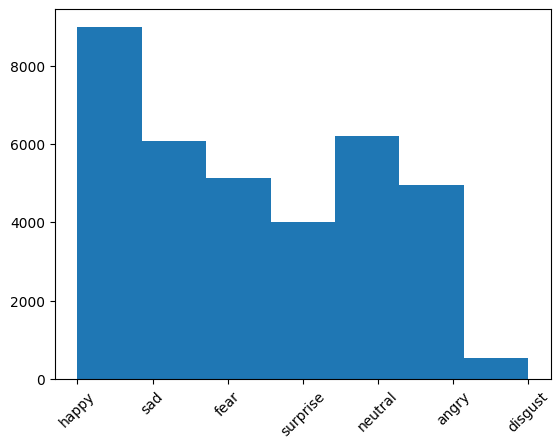

In [192]:
img_size = 48 #By default, the images in FER2013 dataset is in 48x48

data = []
labels = []

# Looping through subfolders in the data path
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    print(emotion_folder)
    if not os.path.isdir(emotion_folder):
        continue
    for img in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(emotions.index(emotion))

# Convert image data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Plot the distribution of the labels, bar graph
plt.hist(labels, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.show()

In [193]:
from sklearn.model_selection import train_test_split

# Load the images and their labels
image_dir = "./dataset/"
labels = []
images = []

emotion_to_valence_arousal = {
    'happy': (0.8, 0.6),
    'sad': (-0.8, -0.6),
    'neutral': (0.0, 0.0),
    'disgust': (-0.6, -0.6),
    'surprise': (0.6, 0.8),
    'angry': (-0.8, 0.8),
    'fear': (0.0, 0.8)
}

for folder in os.listdir(image_dir):
    for file in os.listdir(os.path.join(image_dir, folder)):
        if file.endswith(".jpg"):
            images.append(img_to_array(load_img(os.path.join(image_dir, folder, file), color_mode="grayscale")))
            labels.append(emotion_to_valence_arousal[folder])  # Map the folder name to a valence-arousal pair

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0

# Reshape the images to 2D
images_2d = images.reshape(images.shape[0], -1)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images_2d, labels, test_size=0.3, random_state=42)

# Reshape the images back to their original shape
train_images = train_images.reshape(-1, images.shape[1], images.shape[2])
test_images = test_images.reshape(-1, images.shape[1], images.shape[2])

In [194]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_images(images):
    # Convert to color
    color_images = [img if img.shape[-1] == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) for img in images]
    return np.array(color_images)

# Apply the preprocessing to both the training and testing data
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

def display_samples(images, true_values, predicted_values, num_samples=9):
    # Choose random indices
    indices = np.random.choice(np.arange(images.shape[0]), size=num_samples, replace=False)

    # Initialize subplots
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    # For each subplot
    for i, idx in enumerate(indices):
        # Get the sample image and its corresponding true and predicted values
        sample_image = images[idx]
        true_value = true_values[idx]
        predicted_value = predicted_values[idx]

        # Display the sample image with the true and predicted valence and arousal rates
        axs[i//3, i%3].imshow(sample_image, cmap='gray')
        axs[i//3, i%3].set_title(f'True: {true_value[0]:.2f}, {true_value[1]:.2f}\nPredicted: {predicted_value[0]:.2f}, {predicted_value[1]:.2f}')

    plt.tight_layout()
    plt.show()

In [195]:
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers.legacy import Adam
from keras.layers import BatchNormalization
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import r2_score, explained_variance_score
from keras.regularizers import l2

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Dense(2, activation="linear")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers[:-4]:
    layer.trainable = False
for layer in baseModel.layers[-4:]:
    layer.trainable = True

def lr_schedule(epoch):
    lr = 1e-3 * (0.9 ** epoch)
    return lr

opt = Adam(lr=1e-3)
model.compile(optimizer=opt, 
              loss='mean_squared_error',  
              metrics=[MeanSquaredError(name='mse'), 
                       MeanAbsoluteError(name='mae')])

model.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0  

/Users/riaacordero/miniconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


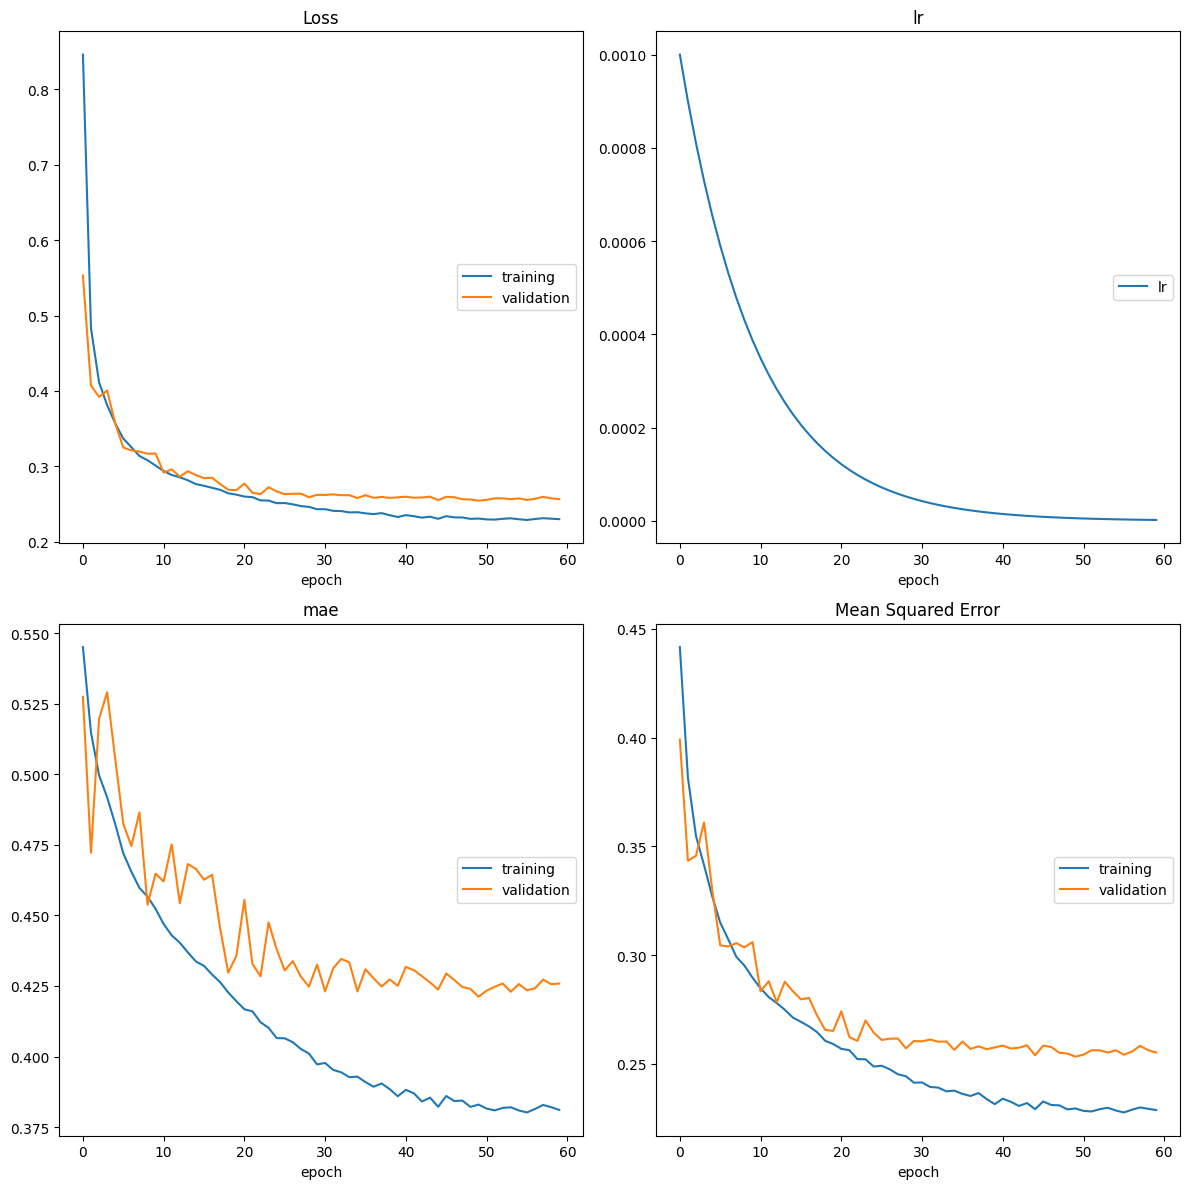

Loss
	training         	 (min:    0.229, max:    0.846, cur:    0.230)
	validation       	 (min:    0.255, max:    0.553, cur:    0.257)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
mae
	training         	 (min:    0.380, max:    0.545, cur:    0.381)
	validation       	 (min:    0.421, max:    0.529, cur:    0.426)
Mean Squared Error
	training         	 (min:    0.228, max:    0.442, cur:    0.229)
	validation       	 (min:    0.253, max:    0.399, cur:    0.255)

Epoch 60: saving model to model_weights.h5
Restoring model weights from the end of the best epoch: 50.
785/785 [==============================] - 27s 34ms/step - loss: 0.2301 - mse: 0.2287 - mae: 0.3811 - val_loss: 0.2565 - val_mse: 0.2552 - val_mae: 0.4259 - lr: 1.9967e-06
Epoch 60: early stopping
  6/337 [..............................] - ETA: 3s  

2023-12-26 01:20:51.494872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


337/337 [==============================] - 4s 11ms/step


In [200]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import CSVLogger, TensorBoard, EarlyStopping, LearningRateScheduler
from livelossplot.inputs.keras import PlotLossesCallback

batch_size = 32
train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)
val_generator = datagen.flow(test_images, test_labels, batch_size=batch_size)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss', save_weights_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')
csv_logger = CSVLogger('training.log')
tensorboard = TensorBoard(log_dir='./result', histogram_freq=0, write_graph=True, write_images=False)

# Create a new instance of the PlotLossesKeras callback
plot_losses = PlotLossesCallback()

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Add it to your list of callbacks
callbacks = [lr_scheduler, plot_losses, checkpoint, reduce_lr, csv_logger, tensorboard, early_stopping]

model.fit(train_generator,
          steps_per_epoch=len(train_images) // batch_size,
          epochs=100,
          validation_data=val_generator,
          validation_steps=len(test_images) // batch_size,
          verbose=1, workers=4,
          callbacks=callbacks)


# Predict the valence-arousal coordinates for the test images
predictions = model.predict(test_images)


In [209]:
# Additional evaluation metrics
r2 = r2_score(test_labels, predictions)
evs = explained_variance_score(test_labels, predictions)  # Corrected line

print(f'R2 Score: {r2:.4f}')
print(f'Explained Variance Score: {evs:.4f}')

R2 Score: 0.2930
Explained Variance Score: 0.2935


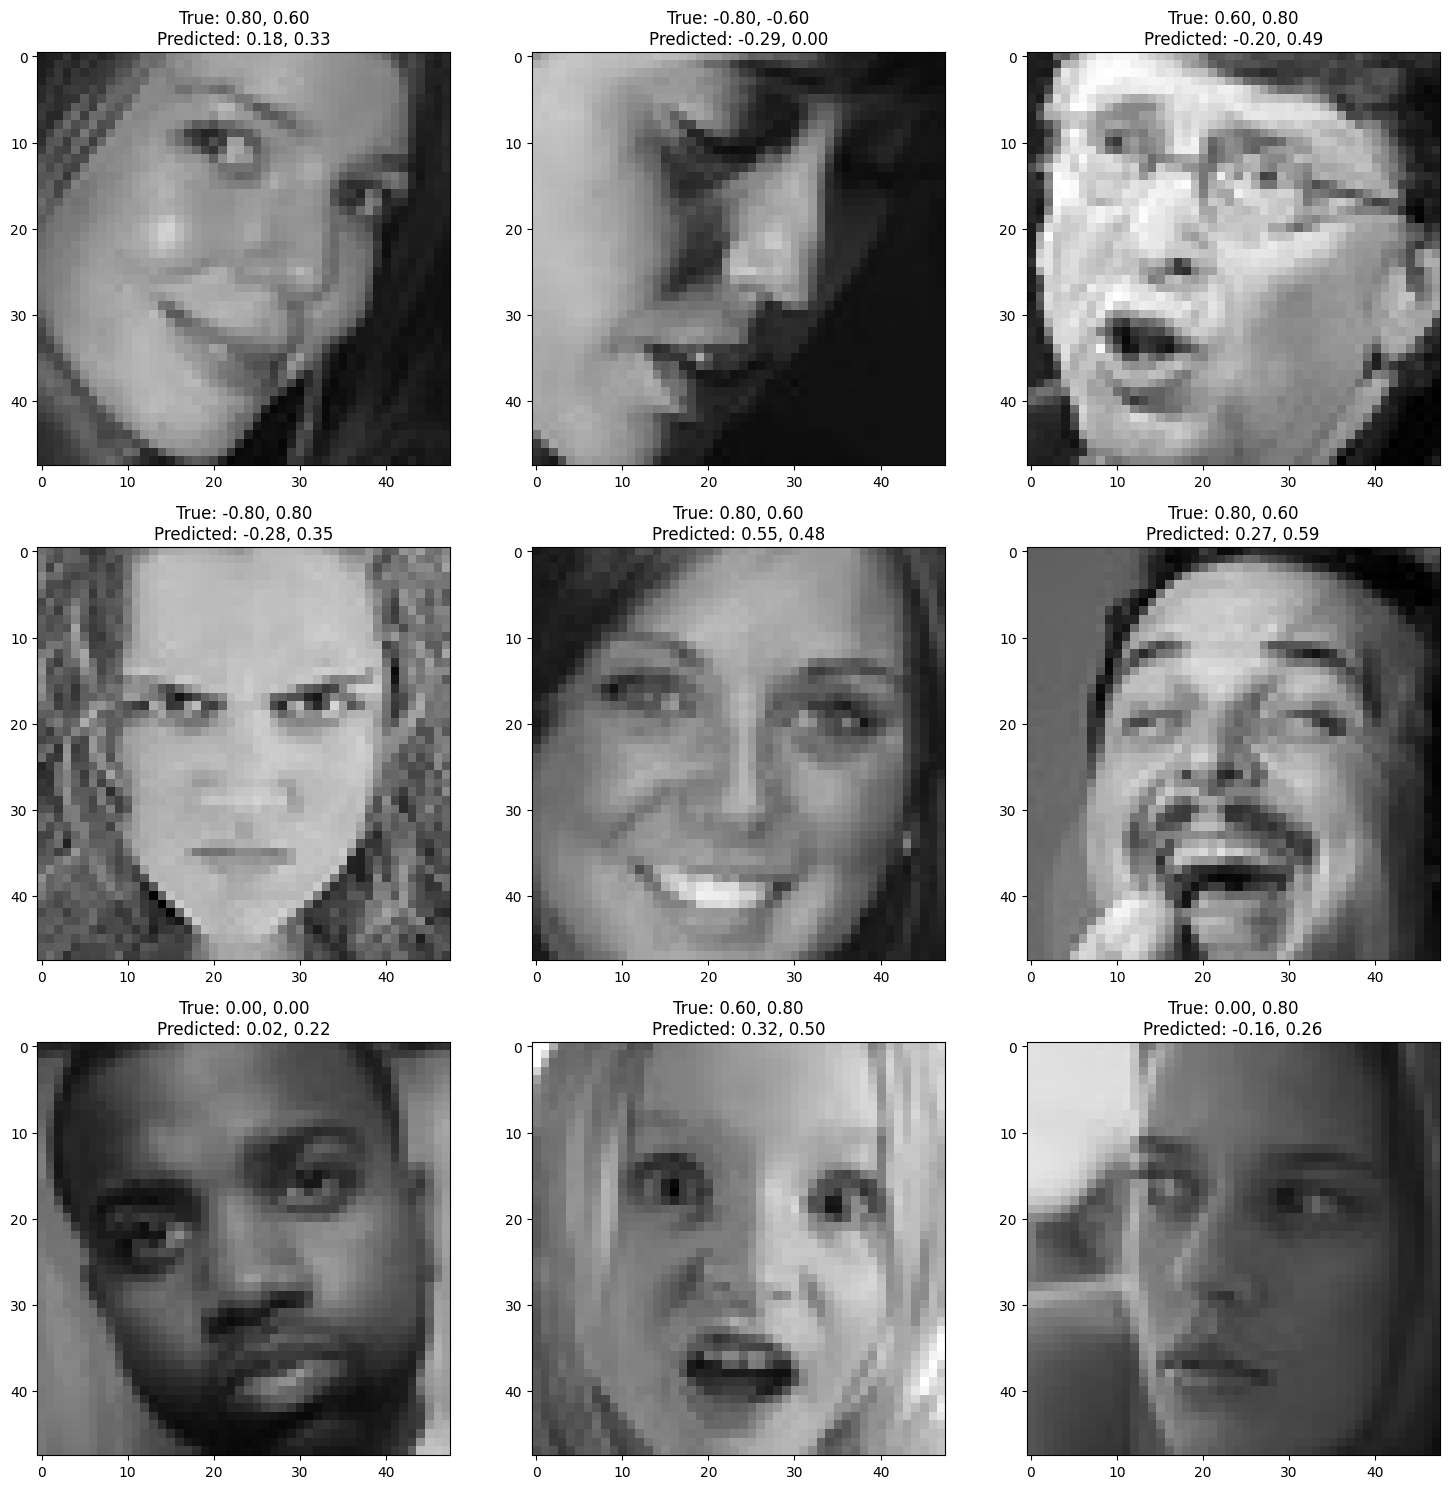

In [213]:
display_samples(test_images, test_labels, predictions)

In [207]:
# Save the model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model's weights
model.save_weights("model_weights.h5")

# Save entire model
model.save("model.h5")

/Users/riaacordero/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


337/337 [==============================] - 4s 11ms/step


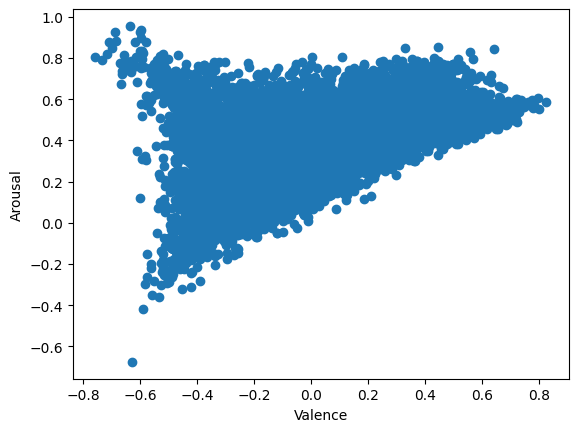

In [208]:
import matplotlib.pyplot as plt

# Predict the valence-arousal coordinates for the test images
predictions = model.predict(test_images)

# Plot the predicted valence-arousal coordinates
plt.scatter(predictions[:, 0], predictions[:, 1])
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers.legacy import Adam
# from keras.regularizers import l1_l2
from keras.layers import BatchNormalization
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import r2_score, explained_variance_score

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# Load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(512, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="linear")(headModel)

n_classes = 7
headModel = Dense(n_classes, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

# Unfreeze the last block and fine-tune
for layer in baseModel.layers[:-4]:
    layer.trainable = False
for layer in baseModel.layers[-4:]:
    layer.trainable = True

# Experiment with different learning rates
def lr_schedule(epoch):
    lr = 1e-3 * (0.9 ** epoch)
    return lr

# Compile the model
opt = Adam(lr=1e-3)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 
                       MeanSquaredError(name='mse'), 
                       MeanAbsoluteError(name='mae')])

model.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0  

/Users/riaacordero/miniconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
